In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests as req
import json
import os


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder


from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # 修改中文字體
plt.rcParams['axes.unicode_minus'] = False # 顯示負號

In [3]:
df2021 = pd.read_csv('所得房價消費分析_處理後_2021.csv')
print(df2021.shape)
df2021.head()

(12276, 13)


,縣市代碼,縣市名稱,鄉鎮市區代碼,鄉鎮市區名稱,平均開立張數,平均開立金額,平均客單價,year,month,縣鄉鎮市區,lng,lat,行業名稱
0,F,新北市,16,鶯歌區,4541,4522267,996,2021,10,新北市鶯歌區,121.349034,24.955179,食品、飲料及菸草製品零售業
1,B,臺中市,57,神岡區,5126,743276,145,2021,10,臺中市神岡區,120.672302,24.264081,餐飲業
2,O,新竹市,1,東 區,5486,1347875,246,2021,10,新竹市東 區,120.995794,24.788493,食品、飲料及菸草製品零售業
3,D,臺南市,70,新市區,5632,799366,142,2021,10,臺南市新市區,120.292618,23.082195,餐飲業
4,T,屏東縣,3,東港鎮,6055,1071876,177,2021,10,屏東縣東港鎮,120.469456,22.465252,餐飲業


一、 actual amount sum 平均 vs 時間

Text(0, 0.5, '金額總和')

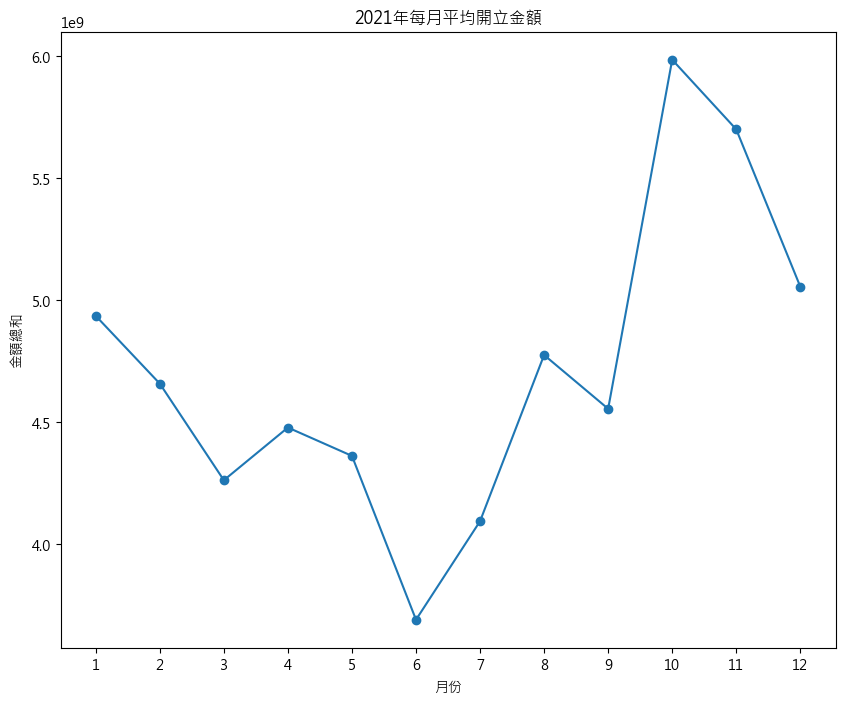

In [6]:
plt.figure(figsize=(10, 8))
df = df2021.groupby('month').sum()
plt.plot(df.index, df['平均開立金額'], marker='o')
plt.title('2021年每月平均開立金額')
plt.xlabel('月份')
plt.xticks(np.arange(1, 13, 1))
plt.ylabel('金額總和')

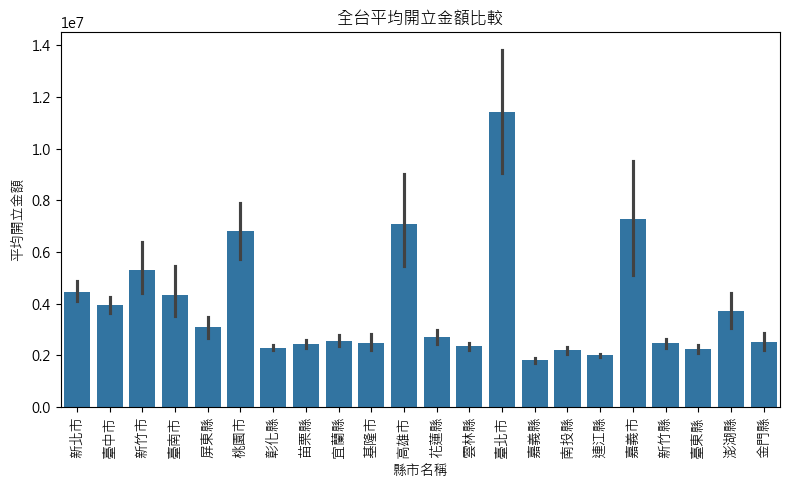

In [7]:
fig , ax = plt.subplots(1, 1, figsize=(8, 5), sharey=True)
sns.barplot(data=df2021, x="縣市名稱", y="平均開立金額", ax=ax)
ax.set_title('全台平均開立金額比較')  # 設定標題
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)  # 旋轉 X 軸標籤避免重疊


# 全局調整
plt.tight_layout()
plt.show()


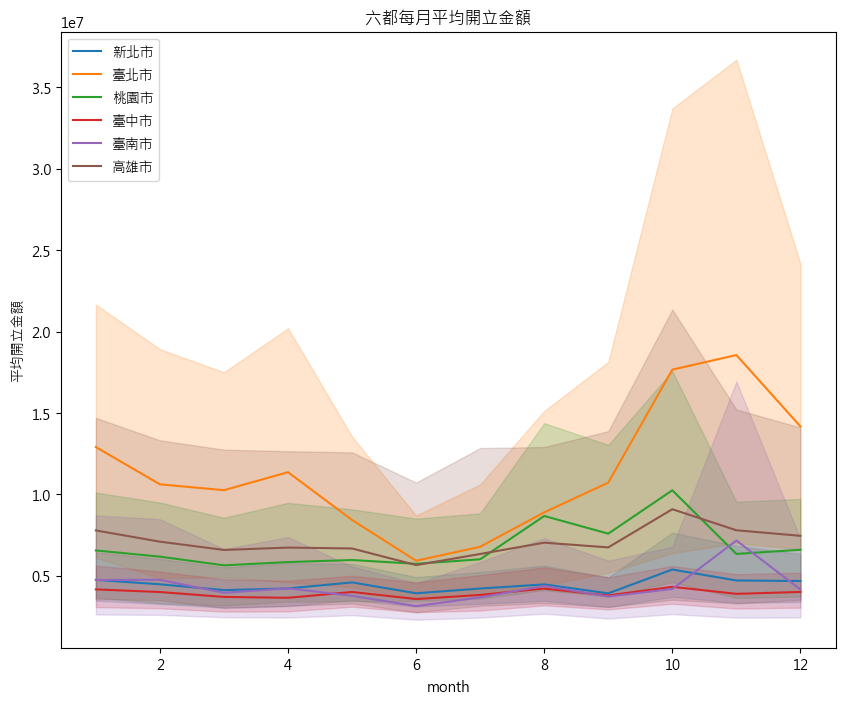

In [8]:
city = ['新北市', '臺北市', '桃園市', '臺中市', '臺南市', '高雄市']
plt.figure(figsize=(10, 8))
for i in range(len(city)):
    sns.lineplot(data=df2021[df2021['縣市名稱'] == city[i]], x='month', y='平均開立金額', label=city[i]) #, ci=None
plt.title('六都每月平均開立金額')
plt.show() 

## 針對問題重新進行優化

In [12]:
# df2021 = df2021[df2021['month'] == 1]
# Features and target variable
X = df2021.drop(columns=['平均開立金額', 'year','縣市代碼','縣市名稱','鄉鎮市區代碼','鄉鎮市區名稱','縣鄉鎮市區']) 
y = df2021['平均開立金額']  

In [4]:
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
categorical_features = ['行業名稱']

# 定義參數網格
param_grid = {
    'iterations': [100, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5, 7]
}

# 初始化模型
model = CatBoostRegressor(loss_function='MAPE', cat_features=categorical_features, verbose=50)

# 使用 Grid Search 進行超參數調優
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_absolute_percentage_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# 輸出最佳參數
print(f"Best parameters found: {grid_search.best_params_}")

# 使用最佳參數進行預測
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}")

X_test['predicted_amount'] = y_pred
X_test['actual_amount'] = y_test

Fitting 3 folds for each of 108 candidates, totalling 324 fits
0:	learn: 0.5298661	total: 46.1ms	remaining: 4.57s
50:	learn: 0.2297998	total: 2.5s	remaining: 2.41s
99:	learn: 0.1973111	total: 4.93s	remaining: 0us
Best parameters found: {'depth': 8, 'iterations': 100, 'l2_leaf_reg': 7, 'learning_rate': 0.1}
Mean Absolute Percentage Error (MAPE): 0.20


In [14]:
#output the trained model
best_model.save_model('catboost_model_ALL_grid.cbm')
Y = best_model.predict(X)
X['預測開立金額'] = Y
X['縣市名稱'] = df2021['縣市名稱']
X['鄉鎮市區名稱'] = df2021['鄉鎮市區名稱']
X['平均開立金額'] = df2021['平均開立金額']

In [15]:
X

,平均開立張數,平均客單價,month,lat,lng,行業名稱,預測開立金額,縣市名稱,鄉鎮市區名稱,平均開立金額
0,4541,996,10,121.349034,24.955179,食品、飲料及菸草製品零售業,1.853910e+06,新北市,鶯歌區,4522267
1,5126,145,10,120.672302,24.264081,餐飲業,9.021481e+05,臺中市,神岡區,743276
2,5486,246,10,120.995794,24.788493,食品、飲料及菸草製品零售業,1.270410e+06,新竹市,東 區,1347875
3,5632,142,10,120.292618,23.082195,餐飲業,9.798856e+05,臺南市,新市區,799366
4,6055,177,10,120.469456,22.465252,餐飲業,1.099275e+06,屏東縣,東港鎮,1071876
...,...,...,...,...,...,...,...,...,...,...
12271,38798,1562,6,121.543846,25.026307,超級市場,1.163039e+07,臺北市,大安區,60582678
12272,24559,125,6,120.300597,23.140671,超級市場,2.011980e+06,臺南市,善化區,3060158
12273,25976,608,6,121.444696,24.965980,零售式量販店,7.754793e+06,新北市,土城區,15801622
12274,22602,427,6,120.664436,24.119969,便利商店,6.584617e+06,臺中市,南 區,9649730


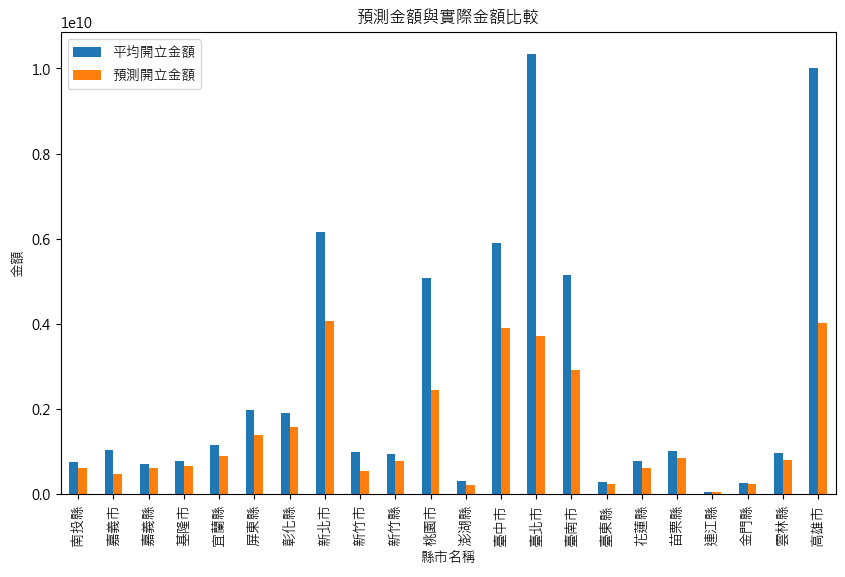

In [16]:
#compare the predicted amount and actual amount by individual city
city = X.groupby('縣市名稱').sum()[['平均開立金額', '預測開立金額']]
city.plot(kind='bar', figsize=(10, 6))
plt.title('預測金額與實際金額比較')
plt.ylabel('金額')
plt.show()

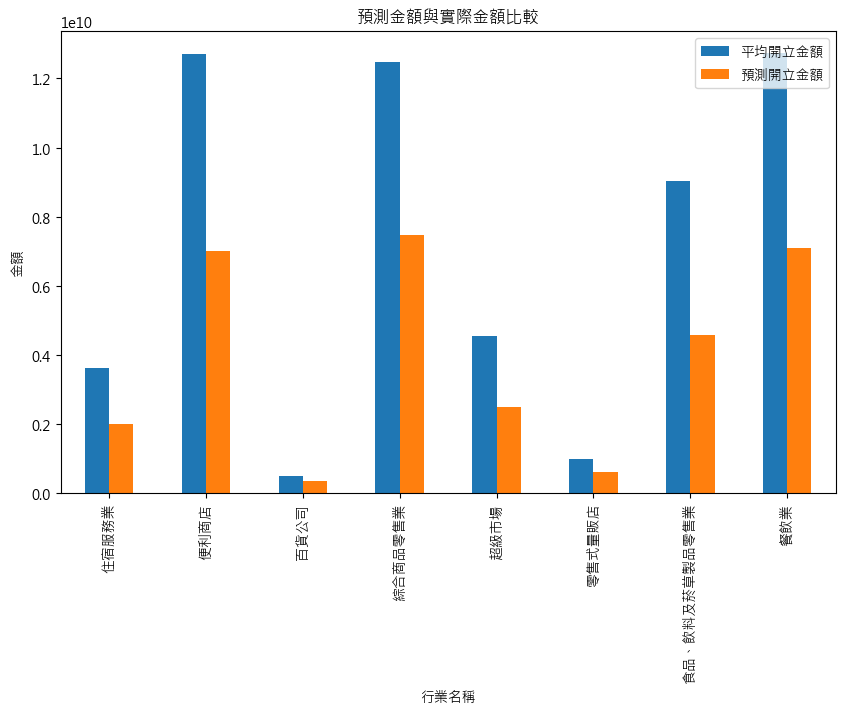

In [17]:
#compare the predicted amount and actual amount by individual industry
industry = X.groupby('行業名稱').sum()[['平均開立金額', '預測開立金額']]
industry.plot(kind='bar', figsize=(10, 6))
plt.title('預測金額與實際金額比較')
plt.ylabel('金額')
plt.show()